# Cirq fundamentals introduction - Google's Quantum Computing Library

In this notebook we will cover fundamentals of [Cirq](https://quantumai.google/cirq/). This is an introductionary notebook, our goal is to get high-level understanding of Cirq's elements. It should you get up to speed for having fun in realm of quantum computing. We will divide this into five chapters - Qubits, Gates and Operations, Circuits and Moments, Simulation and Visualization.

## Part 1: Qubits

As you might know, the most basic element in quantum computing is the qubit - a basic unit of quantum information. There are three ways to create qubits, depending on how they interact with each other.
First, we have `cirq.NamedQubit` - those are labeled by a name. We can create a single qubit with a specific name or any number of them with a specific prefix!

In [15]:
import cirq
import numpy as np
nq1 = cirq.NamedQubit("Named Qubit!")
nqs = cirq.NamedQubit.range(10, prefix="prefix-")
print(nq1)
print(nqs)

Named Qubit!
[cirq.NamedQubit('prefix-0'), cirq.NamedQubit('prefix-1'), cirq.NamedQubit('prefix-2'), cirq.NamedQubit('prefix-3'), cirq.NamedQubit('prefix-4'), cirq.NamedQubit('prefix-5'), cirq.NamedQubit('prefix-6'), cirq.NamedQubit('prefix-7'), cirq.NamedQubit('prefix-8'), cirq.NamedQubit('prefix-9')]


Then we have `cirq.LineQubit` - which are labeled by a number in a linear array. This way we can talk about qubits that are adjacent to each other. We can add or subtract from this qubit to get a qubit "right" or "left" from the original one.

In [2]:
lq = cirq.LineQubit(7)
lqs = cirq.LineQubit.range(3)
lq0, lq1, lq2 = lqs
print(lq)
print(lqs)
print("Is lq0 neighbour of lq1?", lq0.is_adjacent(lq1))
print("Is lq0 neighbour of lq2?", lq0.is_adjacent(lq2))
print("Neighbours of lq1", lq1.neighbors())
print("Neighbours of lq2", lq2.neighbors())
print("Neighbours of lq2 that were actually declared", lq2.neighbors(qids = lqs))
print("Qubit three positions 'right' of lq2 is", lq2 + 3)

q(7)
[cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2)]
Is lq0 neighbour of lq1? True
Is lq0 neighbour of lq2? False
Neighbours of lq1 {cirq.LineQubit(0), cirq.LineQubit(2)}
Neighbours of lq2 {cirq.LineQubit(1), cirq.LineQubit(3)}
Neighbours of lq2 that were actually declared {cirq.LineQubit(1)}
Qubit three positions 'right' of lq2 is q(5)


Last but not least is `cirq.GridQubit` which is labeled by a point in two dimensions. Of course, then the concept of adjacency is extended to 2 dimensions. There are also a few convenience methods for creating specific shapes.

In [3]:
gq1_2 = cirq.GridQubit(1, 2)
square_gqs = cirq.GridQubit.square(3)
rect_qgs = cirq.GridQubit.rect(2, 3)

print(gq1_2)
print("Qubits in a square", square_gqs)
print("Qubits in a rectangle", rect_qgs)

sq1_1 = square_gqs[4]
print(sq1_1.neighbors(qids = square_gqs))
rq0_2 = square_gqs[2]
rq1_0 = square_gqs[3]
print("In rectangular grid, is (0, 2) adjacent to (1, 0) -", rq0_2.is_adjacent(rq1_0))

q(1, 2)
Qubits in a square [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2), cirq.GridQubit(2, 0), cirq.GridQubit(2, 1), cirq.GridQubit(2, 2)]
Qubits in a rectangle [cirq.GridQubit(0, 0), cirq.GridQubit(0, 1), cirq.GridQubit(0, 2), cirq.GridQubit(1, 0), cirq.GridQubit(1, 1), cirq.GridQubit(1, 2)]
{cirq.GridQubit(2, 1), cirq.GridQubit(1, 2), cirq.GridQubit(0, 1), cirq.GridQubit(1, 0)}
In rectangular grid, is (0, 2) adjacent to (1, 0) - False


## Part 2: Gates and Operations

Now it is time for Gates and Operations! Qubits on their own are very interesting, but (conceptually) they are not very dynamic. They are what they are. So let's try to manipulate them using `Gate` and `Operation`. Taking it straight from the [documentation](https://quantumai.google/cirq/start/basics#gates_and_operations)

> - A Gate is an effect that can be applied to a set of qubits.
>  - An Operation is a gate applied to a set of qubits.

In very crude terms you can think about a `Gate` as a "function" and `Operation` as a result of applying `Gate` to qubits or qubits - with the caveat that `Operation` will actually be evaluated during simulation. There are tons of gates already available, and you can even create your own!

In [33]:
q0, q1, q2 = cirq.LineQubit.range(3)

x_gate = cirq.X
print("X gate -", x_gate)
print("X operation -", x_gate(q0))

sqrt_x = cirq.X ** 0.5
print("Square root of X operation -", sqrt_x(q2))
cnot_gate = cirq.CNOT
cnot_operation = cnot_gate(q1, q2)
print("CNOT gate", cnot_gate)
print("CNOT operation", cnot_operation)

# Your own gate from a unitary matrix!
unitary_matrix = np.matrix([[1j, 0], [0, 1j]])
assert (np.identity(2) == unitary_matrix.H * unitary_matrix).all()
assert (np.identity(2) == unitary_matrix * unitary_matrix.H).all()


class QuantumGacekGate(cirq.Gate):
    def __init__(self):
        super(QuantumGacekGate, self)

    def _num_qubits_(self) -> int:
        return 1

    def _unitary_(self):
        return unitary_matrix

    def _circuit_diagram_info_(self, args):
        return "QC"


X gate - X
X operation - X(q(0))
Square root of X operation - X**0.5(q(2))
CNOT gate CNOT
CNOT operation CNOT(q(1), q(2))


## Part 3: Circuits and Moments

Okay, given qubits and gates now we can get to building circuits. You might have intuition about what a circuit is - a collection of qubits and gates operating on those qubits, and that is good intuition. From Cirq's perspective though, `Circuit` is a collection of `Moment`s. You can think about a moment as a slice of time (duh), By default, Cirq will try to execute every operation as early as possible (moving "left" on the circuit), but we can of course override that behaviour.

In [81]:
q0, q1, q2 = cirq.NamedQubit.range(3, prefix="q_")

# We can operations qubits one by one
circuit_1 = cirq.Circuit()
circuit_1.append(cirq.H(q0))
circuit_1.append(cirq.H(q1))
circuit_1.append(cirq.SWAP(q1, q2))
print("Circuit 1")
print(circuit_1)
print("Circuit 1 Moments")
print(circuit_1.moments)
print("######")

# We can append operations in a list
circuit_2 = cirq.Circuit()
circ2_qubits = cirq.LineQubit.range(4)
circuit_2.append([cirq.H(q) for q in circ2_qubits])
print(circuit_2)
print(circuit_2.moments)
print("######")

# We can pass operations to the constructor
circuit_3 = cirq.Circuit(
    [cirq.CNOT(cirq.NamedQubit("A"), cirq.NamedQubit("B"))] + [cirq.Z(q) for q in cirq.LineQubit.range(2)])
print(circuit_3)
print(circuit_3.moments)


Circuit 1
q_0: ───H───────

q_1: ───H───×───
            │
q_2: ───────×───
Circuit 1 Moments
[cirq.Moment(
    cirq.H(cirq.NamedQubit('q_0')),
    cirq.H(cirq.NamedQubit('q_1')),
), cirq.Moment(
    cirq.SWAP(cirq.NamedQubit('q_1'), cirq.NamedQubit('q_2')),
)]
######
0: ───H───

1: ───H───

2: ───H───

3: ───H───
[cirq.Moment(
    cirq.H(cirq.LineQubit(0)),
    cirq.H(cirq.LineQubit(1)),
    cirq.H(cirq.LineQubit(2)),
    cirq.H(cirq.LineQubit(3)),
)]
######
0: ───Z───

1: ───Z───

A: ───@───
      │
B: ───X───
[cirq.Moment(
    cirq.CNOT(cirq.NamedQubit('A'), cirq.NamedQubit('B')),
    cirq.Z(cirq.LineQubit(0)),
    cirq.Z(cirq.LineQubit(1)),
)]


## Part 4: Simulation

Okay, we declared multiple circuits, but now it is time for real fun! Simulating our quantum circuits. Of course, Cirq comes with its very own `cirq.Simulator` that can (as per [documentation](https://quantumai.google/cirq/start/basics#simulation)) simulate up to 20 qubits.

In [78]:
simulator = cirq.Simulator()
results_1 = simulator.simulate(circuit_1)
print(results_1)
print("####")
for i, step in enumerate(simulator.simulate_moment_steps(circuit_1)):
    print('state at step %d: %s' % (i, np.around(step.state_vector(), 3)))

measurements: (no measurements)

qubits: (cirq.NamedQubit('q_0'),)
output vector: 0.707|0⟩ + 0.707|1⟩

qubits: (cirq.NamedQubit('q_1'),)
output vector: |0⟩

qubits: (cirq.NamedQubit('q_2'),)
output vector: 0.707|0⟩ + 0.707|1⟩

phase:
output vector: |⟩
####
state at step 0: [0.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0.5+0.j 0. +0.j 0.5+0.j 0. +0.j]
state at step 1: [0.5+0.j 0.5+0.j 0. +0.j 0. +0.j 0.5+0.j 0.5+0.j 0. +0.j 0. +0.j]


In [82]:
# But what about measurements?
circuit_2.append(cirq.measure(circ2_qubits, key="m"))
results_2 = simulator.simulate(circuit_2)

In [91]:
# Sampling time!
circ2_samples = simulator.run(circuit_2, repetitions=10000)
print(circ2_samples.histogram(key="m"))


Counter({4: 662, 13: 655, 15: 653, 3: 650, 14: 646, 5: 642, 1: 639, 2: 635, 7: 623, 9: 623, 12: 619, 6: 604, 0: 597, 10: 591, 8: 586, 11: 575})


## Part 5: Visualizing results
Now, last but not least - we can visualize the results - Cirq provides a neat method called `plot_state_histogram`.

Counter({3: 672, 10: 645, 13: 640, 0: 637, 7: 637, 4: 632, 5: 631, 2: 628, 15: 628, 1: 621, 6: 617, 8: 615, 12: 604, 14: 603, 11: 601, 9: 589})


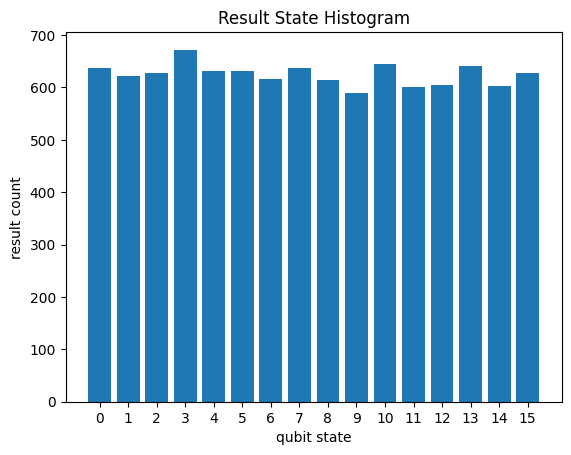

In [90]:
import matplotlib.pyplot as plt
cirq.plot_state_histogram(circ2_samples, plt.subplot())
plt.show()